note: multilinear regression with 3 cameras to compare with KNN from Anne

In [1]:
#- main machine learning libraries used

# import tensorflow
import tensorflow as tf
import tensorflow.keras as keras  
import sklearn
from sklearn.metrics import mean_squared_error, mean_absolute_error



#- other libraries used
import itertools
import numpy as np
import os
import math
import pandas as pd
import matplotlib.pyplot as plt 
from platform import python_version
from datetime import datetime as dt
# import hydroeval as he # includes nash suchcliff efficiency (nse) goodness of fit similar to R^2
from pygam import GAM, LinearGAM, s, f, te  #  import a GAM that’s made for regression problems


In [2]:
python_version()

'3.9.13'

In [3]:
tf.__version__

'2.9.1'

In [4]:
home_dir = "/Users/ehsanmos/MLP_dataset/atmmodels/atmmodel_k_zero_old"

# with 3 cameras and 10pnts



# original atmmodel.csv
#****************************

plot_name_tag = 'april'
atmmodel = "atmmodel_april_2016_k_zero.csv" # prediction with npts=10 

#****************************

# plot_name_tag = 'july'
# atmmodel = "atmmodel_july_2016_k_zero.csv"

#****************************
# # atmmodel = "atmmodel_april_2016_k_zero_npts_larger10.csv" # prediction with npts=10 


# with 9 cameras
# atmmodel = "atmmodel_july_2016_k_zero_9cams4bands.csv"

atmmodel_fp = os.path.join(home_dir, atmmodel)

In [5]:
plot_output_dir = home_dir

In [6]:
print(atmmodel_fp)

if (not os.path.isfile(atmmodel_fp)):
    raise SystemExit()
else:
    print("input dataset found!")

/Users/ehsanmos/MLP_dataset/atmmodels/atmmodel_k_zero_old/atmmodel_april_2016_k_zero.csv
input dataset found!


In [7]:
# read data

training_ds = pd.read_csv(atmmodel_fp, engine='python')

print(training_ds.shape)
print(training_ds.columns)

(43298, 15)
Index(['path', 'orbit', 'block', 'line', 'sample', 'lat', 'lon', 'an', 'ca',
       'cf', 'rms', 'weight', 'npts', 'cloud', 'var'],
      dtype='object')


### >>> drop unnecesary columns and build dataset with 9 cameras

In [8]:
# excluce_columns_old= ['path', 'orbit', 'img_block', 'line', 'sample', 'firstLat', 'firstLon', 'weight', 'npts', 'cloud', 'var']


excluce_columns_rmLatLon = ['path', 'orbit', 'block', 'line', 'sample', 'lat', 'lon', 'weight', 'npts', 'cloud', 'var']
training_ds = training_ds.drop(excluce_columns_rmLatLon, axis=1)


# excluce_columns_keepLatLon = ['path', 'orbit', 'block', 'line', 'sample', 'weight', 'npts', 'cloud', 'var']
# training_ds = training_ds.drop(excluce_columns_keepLatLon, axis=1)



In [9]:
print('we are using %s columns in our training dataset:' %len(training_ds.columns))
print(training_ds)  # columns should be only 9 cameras + rms 

we are using 4 columns in our training dataset:
             an        ca         cf        rms
0      4.883254  8.022488  16.350180  14.200000
1      4.839653  7.978888  16.350180  11.740000
2      4.752452  7.891687  16.044976   9.062000
3      4.796053  7.848086  15.870574  14.905000
4      4.752452  7.848086  16.044976  12.299000
...         ...       ...        ...        ...
43293  0.539080  0.596643   1.035216  10.860000
43294  0.553699  0.592988   1.065825   9.081818
43295  0.551415  0.600754   1.058515   8.576000
43296  0.532227  0.626338   1.042525   7.840000
43297  0.502481  0.701360   1.021496   8.550000

[43298 rows x 4 columns]


In [10]:
# # rename column names
# train_dataset.rename(columns={' an':'an', ' ca':'ca', ' cf':'cf', ' rms':'rms'}, inplace=True)
# print(train_dataset.columns)
# print(type(train_dataset))

### look at distribution of data/ before cleaning

array([[<AxesSubplot:title={'center':'an'}>,
        <AxesSubplot:title={'center':'ca'}>],
       [<AxesSubplot:title={'center':'cf'}>,
        <AxesSubplot:title={'center':'rms'}>]], dtype=object)

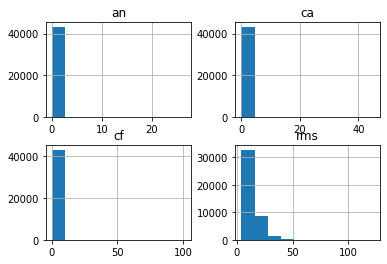

In [11]:
training_ds.hist(bins=10)


## >>> cleaning dataset >>>

In [12]:
training_ds.max()

an      26.534945
ca      45.249064
cf     101.112106
rms    122.655217
dtype: float64

## >>> remove negative values

- we want to train our models, so we will remove negative values, NAN values, masked values such as land mask, etc. 

In [13]:
print('before dropping negative values: (%s, %s)' %training_ds.shape)

#- remove/ drop negative values from all input features

training_ds.drop((training_ds[training_ds['an'] < 0.0].index) | 
                (training_ds[training_ds['ca'] < 0.0].index) | 
                (training_ds[training_ds['cf'] < 0.0].index), inplace=True)



#- remove/ drop negative values from all input features

# training_ds.drop((training_ds[training_ds['da'] < 0.0].index) | 
#                 (training_ds[training_ds['ca'] < 0.0].index) | 
#                 (training_ds[training_ds['ba'] < 0.0].index) |
#                 (training_ds[training_ds['aa'] < 0.0].index) |
#                 (training_ds[training_ds['anr'] < 0.0].index) |
#                 (training_ds[training_ds['af'] < 0.0].index) |
#                 (training_ds[training_ds['bf'] < 0.0].index) |
#                 (training_ds[training_ds['cf'] < 0.0].index) |
#                 (training_ds[training_ds['df'] < 0.0].index), inplace=True)


print('after dropping negative values: (%s, %s)' %training_ds.shape)

before dropping negative values: (43298, 4)
after dropping negative values: (43298, 4)


/var/folders/cg/r5rsmy1146d38c9kj97z_55w0000gn/T/ipykernel_2243/117202112.py:5: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead.
  training_ds.drop((training_ds[training_ds['an'] < 0.0].index) |


## >>> outlier detection and removal >>>

### Removing reflectance values as outliers in all cameras

In [14]:
cam_outlier = 1

print(' remove cameras outliers > %s' %cam_outlier)

training_ds.drop(training_ds[(training_ds['ca'] > cam_outlier) |
                           (training_ds['an'] > cam_outlier) |
                           (training_ds['cf'] > cam_outlier)].index, inplace=True)



# training_ds.drop(training_ds[(training_ds['da'] > cam_outlier) |
#                            (training_ds['ca'] > cam_outlier) |
#                            (training_ds['ba'] > cam_outlier) |
#                            (training_ds['aa'] > cam_outlier) |
#                            (training_ds['anr'] > cam_outlier) |
#                            (training_ds['af'] > cam_outlier) |
#                            (training_ds['bf'] > cam_outlier) |
#                            (training_ds['cf'] > cam_outlier) |
#                            (training_ds['df'] > cam_outlier)].index, inplace=True)

 remove cameras outliers > 1


### Method 1: removing roughness values > 200 cm

In [15]:
# training_ds.drop((training_ds[training_ds['rms'] > 30].index), inplace=True)

### Method 2: removing roughness values with Interquartile Range Method (IQR)

- Method: find 25 and 75 percentiles in data, calculate inter-quartile range (IQR), set the cut off threshold, and remove outliers from data

In [16]:
#- identify outliers in roughnes valueswith interquartile range (IQRange)

def rms_outlier_removal(dataset_df: pd.DataFrame) -> pd.DataFrame:
    
    from numpy import percentile

    def remove_outliers_IQR(df, cutoff):
        df.drop((df[df['rms'] > cutoff].index), inplace=True)
        print('Removing outliers (IQR method): after dropping roughness values > %.1f in dataset; new shape= (%s,%s)' %(cutoff, df.shape[0], df.shape[1]))
        return 0 # because inplace=True

    #- extract data 
    data = dataset_df.loc[:,'rms']  # mean_ATM_roughness == rms

    print(type(data))
    #- calculate InterQuartile Range == IQR
    q25, q75 = percentile(data, 25), percentile(data, 75)
    iqr = q75 - q25
    print('Percentiles: 25th= %.3f (cm), 75th= %.3f (cm), InterQuartile Range= %.3f (cm)' % (q25, q75, iqr))
    #- calculate the outlier cutoff
    cut_off = iqr * 3
    lower, upper = q25 - cut_off, q75 + cut_off
    print('lower cutoff= %.1f, upper cutoff= %.1f' % (lower, upper))
    #- identify outliers
    outliers = [x for x in data if x > upper] # list comprehension method
    print('Identified outliers: %d \n' % len(outliers))
    #- remove outliers
    remove_outliers_IQR(dataset_df, upper)
    
    return dataset_df


In [17]:
training_ds = rms_outlier_removal(training_ds)

<class 'pandas.core.series.Series'>
Percentiles: 25th= 7.439 (cm), 75th= 16.263 (cm), InterQuartile Range= 8.824 (cm)
lower cutoff= -19.0, upper cutoff= 42.7
Identified outliers: 98 

Removing outliers (IQR method): after dropping roughness values > 42.7 in dataset; new shape= (16620,4)


In [18]:
# def check_nan_in_DF(training_ds: pd.DataFrame):
    
#     if (training_ds['da'].isnull().values.any() | 
#         training_ds['ca'].isnull().values.any() | 
#         training_ds['ba'].isnull().values.any() |
#         training_ds['aa'].isnull().values.any() |
#         training_ds['anr'].isnull().values.any() |
#         training_ds['af'].isnull().values.any() |
#         training_ds['bf'].isnull().values.any() |
#         training_ds['cf'].isnull().values.any() |
#         training_ds['df'].isnull().values.any()):

#         print('found NAN in one DF column... removing NAN')
#         training_ds.dropna(axis=0, inplace=True)
#     else:
#         print('did not find NAN in dataset') 



def check_nan_in_DF(training_ds: pd.DataFrame):
    
    if (
        training_ds['ca'].isnull().values.any() | 
        training_ds['an'].isnull().values.any() |
        training_ds['cf'].isnull().values.any()):

        print('found NAN in one DF column... removing NAN')
        training_ds.dropna(axis=0, inplace=True)
    else:
        print('did not find NAN in dataset') 

In [19]:
check_nan_in_DF(training_ds)

did not find NAN in dataset


In [20]:
#~ double check for any negative values in all columns

if ((training_ds.values < 0).any()):
    print('found some negative values in DF! something is wrong!')
else:
    print('double check: did not find any negative value in DF!')

double check: did not find any negative value in DF!


In [21]:
## check values after cleaning dataset
training_ds.max()

an      0.943680
ca      0.987624
cf      0.999990
rms    42.730000
dtype: float64

In [22]:
training_ds

,an,ca,cf,rms
56,0.735176,0.838593,0.864487,25.555000
57,0.760427,0.855963,0.874781,20.466667
58,0.743540,0.856285,0.877676,16.176250
59,0.767343,0.856285,0.879284,25.000000
60,0.771203,0.858215,0.879284,22.646667
...,...,...,...,...
43226,0.783715,0.872968,0.911412,7.362500
43227,0.785514,0.871394,0.936592,7.605000
43228,0.788212,0.872294,0.966268,8.166667
43229,0.795406,0.872743,0.995494,7.540000


## look at distribution of data- after cleaning

array([[<AxesSubplot:title={'center':'an'}>,
        <AxesSubplot:title={'center':'ca'}>],
       [<AxesSubplot:title={'center':'cf'}>,
        <AxesSubplot:title={'center':'rms'}>]], dtype=object)

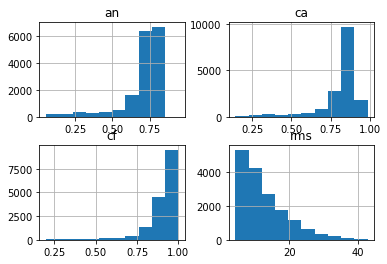

In [23]:
training_ds.hist(bins=10)

## >>> 1) Shuffle dataset

In [24]:
# shuffle dataset

from sklearn.utils import shuffle

train_dataset = shuffle(training_ds)

## >>> 2) Split dataset to train-test

In [25]:
#- split data set to X and Y

X = train_dataset.iloc[:, :-1] # to select up to last column of dataset OR [:, 0:3]
Y = train_dataset.iloc[:, -1:] # to select last column of DF

print(X.shape)
print(Y.shape)

(16620, 3)
(16620, 1)


In [26]:
# change to list? faster?
# XX = 
XX = X.values.tolist()
YY = Y.values.tolist()

In [27]:
#- now split dataset to train-test

from sklearn.model_selection import train_test_split

#- we use this function to split data-- from here because we are usiong SKlearn library, we change all data structures from Pandas DF to numpy
# X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), Y.to_numpy(), test_size=0.2, random_state=123) # Q- input is DF or numpy array?


testdata_size = 0.3
print("test size= %d percent" %(testdata_size*100))
x_train, x_test, y_train, y_test = train_test_split(XX, YY, test_size=testdata_size, random_state=123) # Q- input is DF or numpy array?

print("train:")
print(len(x_train))
print(len(y_train))

print("\ntest:")
print(len(x_test))
print(len(y_test))


test size= 30 percent
train:
11634
11634

test:
4986
4986


## >>> 3) rescale data

In [28]:
# from sklearn.preprocessing import StandardScaler

# scaler_x = StandardScaler()
# scaler_y = StandardScaler()

# x_train_scaled = scaler_x.fit(x_train).transform(x_train) # returns data w/ mean 0 & std 1
# y_train_scaled = scaler_y.fit(y_train).transform(y_train)
# x_test_scaled = scaler_x.fit(x_test).transform(x_test)
# y_test_scaled = scaler_y.fit(y_test).transform(y_test)

In [29]:
# ret_x_train = plt.hist(x_train_scaled)
# plt.show()

# pd.DataFrame(x_train_scaled)['???'].hist(bin=10)

In [30]:
# ret_y_train = plt.hist(y_train_scaled)
# plt.show()

In [31]:
def MBE(y_obs: np.array, 
        y_model: np.array):
    '''
    Parameters:
        y_true (array): Array of observed values
        y_pred (array): Array of prediction values

    Returns:
        mbe (float): Biais score
    '''
#     y_true = np.array(y_true)
#     y_pred = np.array(y_pred)
#     y_true = y_true.reshape(len(y_true),1)
#     y_pred = y_pred.reshape(len(y_pred),1)   


#     diff = (y_obs - y_model) # if + ==> models underestimates target; if - ==> model overestimates target
    diff = (y_model - y_obs) # if + == models overestimates target; else model underestimates target

    
    mbe = diff.mean()
    print('MBE = %.3f' %mbe) # with 3 numbers after decimal point == 3 decimal places
#     print('MBE = ', mbe)

    
    return 0

## >>> Simple Linear Regression >>>

train simple LR with 2 parameters to estimate

In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Create linear regression object 
lr_model = LinearRegression() # create an estimator obj
lr_model.get_params()

# Fit alg. to training dataset/Train the model using the training sets- here we use X_train(3 features)
lr_model.fit(x_train, y_train) # fit(X,y) will fit data to our algortihm and makes it learn from data == training step

lr_train_score = lr_model.score(x_train, y_train)
print("R^2 train (score): %.2f" %lr_train_score)

y_train_pred_lr = lr_model.predict(x_train)
print('RMSE train: %.2f' %math.sqrt(mean_squared_error(y_train, y_train_pred_lr))) # square root of MSE.
print('MAE train: %.2f' %mean_absolute_error(y_train, y_train_pred_lr))
print(MBE(y_train, y_train_pred_lr))


# NSE-traing
# nse_lr = he.evaluator(he.nse, y_train, y_train_pred_lr)  # order(prediction,target)
# print('NSE train: %.2f' %nse_lr)
# # print(lr_model.coef_)


R^2 train (score): 0.08
RMSE train: 6.60
MAE train: 5.11
MBE = 0.000
0


3 Best metrics to evaluate Regression Model:
- R^2: shows how well the model can fit training data/variables
- RMSE: is a measure of prediction error; it gives larger penalization to big prediction error by square it
- MAE: it treats all errors the same
- MBE: 


notes:  MBE is primarily used to estimate the average bias in the model and to decide if any steps need to be taken to correct the model bias. The MBE, MAE, and RMSE are related by the following inequalities: .


Model evaluation helps you to understand the performance of your model and makes it easy to present your model to other people.
source: https://towardsdatascience.com/what-are-the-best-metrics-to-evaluate-your-regression-model-418ca481755b

In [33]:
# # calculate R-squared of regression model
# r_squared = mlr_model.score(X, Y)
# print('R^2 training: %s' %round(r_squared, 2))

R^2 test: 0.06
RMSE test: 6.87
MAE test: 5.26
MBE = 0.026
0


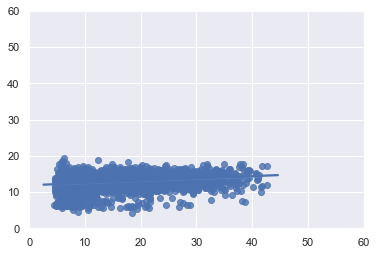

In [34]:
# Predict using the linear model- on specific block data- on transect data
# x_test = 'open 3 MISR cameras that create transect block, create x_test dataset from 3 cameras (an, ca, cf), and then make prediction '
y_pred_lr = lr_model.predict(x_test)


######## plot 
import seaborn as sns

sns.set_theme(color_codes=True)
fig, ax = plt.subplots()

sns.regplot(x=y_test, y=y_pred_lr, truncate=False, ax=ax)#, color='g')

ax.set_xlim(0, 60)
ax.set_ylim(0, 60)
# plt.show()

plot_name = 'simpleLinearReg_'+plot_name_tag
plt.savefig(os.path.join(plot_output_dir, plot_name))



r2_model = r2_score(y_test, y_pred_lr)
print('R^2 test: %s' %round(r2_model,2))
print('RMSE test: %.2f' %math.sqrt(mean_squared_error(y_test, y_pred_lr))) # square root of MSE.
print('MAE test: %.2f' %mean_absolute_error(y_test, y_pred_lr))
print(MBE(y_test, y_pred_lr))

# NSE
# nse_lr = he.evaluator(he.nse, y_pred_lr, y_test)  # order(prediction,target)
# print('NSE: %.2f' %nse_lr)


## >>> Polynomial linear regression >>>

Although this model allows for a nonlinear relationship between Y and X, polynomial regression is still considered linear regression since it is linear in the regression coefficients. it means relations of Y with respect to X is linear == degree of equation (power of X) is 1 so the relationship has power of 1

R^2 train: 0.11
RMSE train: 6.47
MAE train: 5.00
MBE = 0.000
0
R^2 test: 0.09
RMSE test: 6.73
MAE test: 5.14
MBE = 0.005
0


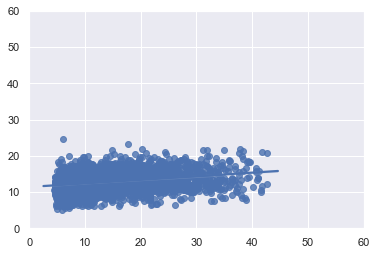

In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import math

poly_feature_matrix = PolynomialFeatures(degree=2) # how nuber of features change?
x_train_poly = poly_feature_matrix.fit_transform(x_train)

# print(x_train.shape)
# print(x_train_poly.shape) # Q- why degree= 3, 3 features turned to 20 features?

poly_linear_reg_model = LinearRegression() # build an instance of the model
# print(poly_linear_reg_model)

poly_linear_reg_model.fit(x_train_poly, y_train) # Then we fit the qlgorithm to our data/train the model
# training model score
ploy_train_score = poly_linear_reg_model.score(x_train_poly, y_train)
print("R^2 train: %.2f" %ploy_train_score)

y_train_poly = poly_linear_reg_model.predict(x_train_poly)
print('RMSE train: %.2f' %math.sqrt(mean_squared_error(y_train, y_train_poly))) # square root of MSE.
print('MAE train: %.2f' %mean_absolute_error(y_train, y_train_poly))
print(MBE(y_train, y_train_poly))


# metrics
# nse_lr = he.evaluator(he.nse, y_train, y_train_poly)  # order(prediction,target)
# print('NSE train: %.2f' %nse_lr)

# predict
x_test_poly = poly_feature_matrix.fit_transform(x_test)
y_pred_plr = poly_linear_reg_model.predict(x_test_poly) # prediction (Y^)

##### R^2 score
r2_plr = r2_score(y_test, y_pred_plr)
print('R^2 test: %s' %round(r2_plr,2))
print('RMSE test: %.2f' %math.sqrt(mean_squared_error(y_test, y_pred_plr))) # square root of MSE.
print('MAE test: %.2f' %mean_absolute_error(y_test, y_pred_plr))
print(MBE(y_test, y_pred_plr))


# NSE
# nse_plr = he.evaluator(he.nse, y_pred_plr, y_test)  # order(prediction,target)
# print('NSE: %.2f' %nse_plr) # shows gof==how model fits data


# print(len(y_test))
# print(len(y_pred_plr))

################################# plot data
# plt.figure(figsize=(10, 6))
# plt.title("poly regression", size=16)
# plt.scatter(y_test, y_pred_plr)
# plt.plot(y_test, y_pred_plr, c="red")
# plt.show()


import seaborn as sns

sns.set_theme(color_codes=True)
fig, ax = plt.subplots()
sns.regplot(x=y_test, y=y_pred_plr, truncate=False, ax=ax)#, color='g')
ax.set_xlim(0, 60)
ax.set_ylim(0, 60)
# plt.show()

plot_name = 'polyLinearReg_'+plot_name_tag
plt.savefig(os.path.join(plot_output_dir, plot_name))

## >>> K-nearest neighbor >>>

In [36]:
from sklearn.neighbors import KNeighborsRegressor

k_neighbors = 5

knn_model = KNeighborsRegressor(n_neighbors=k_neighbors)

knn_model.fit(x_train, y_train) # fit algorithm to data and train it

# training score
knn_train_score = knn_model.score(x_train, y_train)
print("R^2 train: %.2f" %knn_train_score)

y_train_pred_knn = knn_model.predict(x_train)
print('RMSE train: %.2f' %math.sqrt(mean_squared_error(y_train, y_train_pred_knn))) # square root of MSE.
print('MAE train: %.2f' %mean_absolute_error(y_train, y_train_pred_knn))
print(MBE(y_train, y_train_pred_knn))

R^2 train: 0.46
RMSE train: 5.04
MAE train: 3.70
MBE = -0.028
0


In [37]:
# performance metrics on train dataset == algorithm is fit to it





R^2 test: 0.2
RMSE test: 6.33
MAE test: 4.56
MBE = -0.090
0


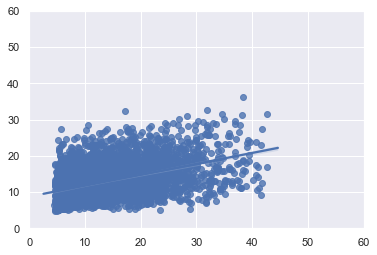

In [38]:
# performance metrics on test dataset

# Predict on dataset which model has not seen before
y_pred_knn = knn_model.predict(x_test)

# report evaluation of mdoel performace on test data
r2_model = r2_score(y_test, y_pred_knn)
print('R^2 test: %s' %round(r2_model,2))
print('RMSE test: %.2f' %math.sqrt(mean_squared_error(y_test, y_pred_knn))) # square root of MSE.
print('MAE test: %.2f' %mean_absolute_error(y_test, y_pred_knn))
print(MBE(y_test, y_pred_knn))


### NSE
# nse_knn = he.evaluator(he.nse, y_pred_knn, y_test)  # order(prediction,target)
# print('NSE: %.2f' %nse_knn)




import seaborn as sns

sns.set_theme(color_codes=True)
fig, ax = plt.subplots()
sns.regplot(x=y_test, y=y_pred_knn, truncate=False, ax=ax)#, color='g')
ax.set_xlim(0, 60)
ax.set_ylim(0, 60)
# plt.show()

plot_name = 'knn_'+plot_name_tag
plt.savefig(os.path.join(plot_output_dir, plot_name))


In [39]:
# change list to np.array 

y_test = np.array(y_test) 
print(type(y_test))
print(type(y_pred_knn))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


### plot histogram for test dataset

In [40]:
# def plot_histogram(obs_ds: np.array, model_ds: np.array):
#     # this function plots histogram of obs vs. modeled data
#     # todo: move label as arg 
    
#     def save_plot(plot_output_dir: str, plot_name: str):
#         plot_fp = os.path.join(plot_output_dir, plot_name)
#         print(plot_fp)
#         plt.savefig(plot_fp)
    
#     #create relative frequency histogram
# #     fig = plt.figure()
# #     ax = fig.add_subplot(111)
# #     ax.hist(data, edgecolor='black', weights=np.ones_like(data) / len(data))
    
#     bin_size = 20
#     plt.hist(obs_ds, density=True, bins=bin_size, label='ATM-derived', color='blue', alpha=0.5)#, weights=np.ones_like(obs_ds) / len(obs_ds))  # density=False would make counts
#     plt.hist(model_ds, density=True, bins=bin_size, label='MISR-derived', color='orange', alpha=0.5)#, weights=np.ones_like(model_ds) / len(model_ds))  # density=False would make counts
#     plt.xlim(0,50)
#     plt.ylim(0,0.25)


#     plt.grid(False)

    
#     plt.xlabel('Roughness (cm)', fontsize = 11)
#     plt.ylabel('Frequency', fontsize = 11)
#     plt.legend(loc="upper right")
#     # plt.title("ATM vs. MISR for %s" %sim_month_hist_label)

#     plt.rc('legend', fontsize=11)    # legend fontsize

    
#     # if we want to save figure, set path and name
#     plot_name = 'histogram_'+plot_name_tag
    
#     save_plot(plot_output_dir, plot_name)
    


#     return 0


In [41]:
def plot_histogram(obs_ds: np.array, model_ds: np.array):
    # this function plots histogram of obs vs. modeled data
    # todo: move label as arg 
    
    def save_plot(plot_output_dir: str, plot_name: str):
        plot_fp = os.path.join(plot_output_dir, plot_name)
        print(plot_fp)
        plt.savefig(plot_fp)
    
    #create relative frequency histogram
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     ax.hist(data, edgecolor='black', weights=np.ones_like(data) / len(data))
    fig, ax = plt.subplots(nrows=1, ncols=1)
    ax.set_facecolor("white")
    fig.patch.set_facecolor('white')
    
    
    bin_size = 20
    plt.hist(obs_ds, density=True, bins=bin_size, label='ATM-derived', color='blue', alpha=0.5)#, weights=np.ones_like(obs_ds) / len(obs_ds))  # density=False would make counts
    plt.hist(model_ds, density=True, bins=bin_size, label='MISR-derived', color='orange', alpha=0.5)#, weights=np.ones_like(model_ds) / len(model_ds))  # density=False would make counts
    
#     ax = plt.axes()
    # Setting the background color of the plot 
    # using set_facecolor() method
    
    plt.xlim(0,50)
    plt.ylim(0,0.25)


    plt.grid(False)

    
    plt.xlabel('Roughness (cm)', fontsize = 11)
    plt.ylabel('Frequency', fontsize = 11)
    plt.legend(loc="upper right")
    # plt.title("ATM vs. MISR for %s" %sim_month_hist_label)

    plt.rc('legend', fontsize=11)    # legend fontsize

    
    # if we want to save figure, set path and name
    plot_name = 'histogram_'+plot_name_tag
    
    
    plt.rcParams["axes.edgecolor"] = "black"
    plt.rcParams["axes.linewidth"] = 1
    
    save_plot(plot_output_dir, plot_name)
    


    return 0


/Users/ehsanmos/MLP_dataset/atmmodels/atmmodel_k_zero_old/histogram_april


0

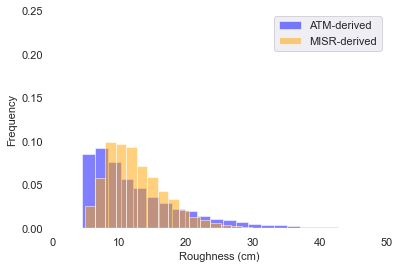

In [42]:
plot_histogram(obs_ds=y_test, model_ds=y_pred_knn)

In [43]:
print(len(x_train))
print(len(y_train))

print(type(x_train))
print(type(y_train))

11634
11634
<class 'list'>
<class 'list'>


In [44]:
# x_train = np.array(x_train)
# y_train = np.array(y_train)

# print(type(x_train))
# print(type(y_train))

In [45]:
# plot_histogram(obs_ds=x_train, model_ds=y_train)

### Q-Q plots for test dataset

In [46]:
## this funtion has a problem/broken

def qq_plot(y_actual: np.array, y_predicted: np.array):
    print(y_actual.shape)
    print(y_predicted.shape)
    
    import scipy.stats as stats
    import matplotlib.pyplot as plt


    residuals = y_actual - y_predicted
    print(type(residuals))
    print(residuals.shape)


    plt.figure(figsize=(7,7))
#     stats.probplot(residuals, dist="norm", plot=plt)
#     plt.title("Normal Q-Q Plot")

    #create Q-Q plot with 45-degree line added to plot
    fig = sm.qqplot(residuals, line='45')
    plt.show()
    
    return 0

In [47]:
# qq_plot(y_actual= y_test, y_predicted= y_pred_knn)

In [48]:
# np.random.seed(0)
# data = np.random.normal(0,1, 1000)
# import statsmodels.api as sm
# import matplotlib.pyplot as plt

# #create Q-Q plot with 45-degree line added to plot
# fig = sm.qqplot(data, line='45')
# plt.show()

In [49]:
type(y_test)

numpy.ndarray

In [50]:
### QQ-plot library did not work here

#import statsmodels.api as sm
# import numpy as np
# import pylab
# import scipy.stats as stats

# # y_test_scaled.sort()
# # y_pred_knn.sort()

# diff = y_test - y_pred_knn

# # actual_data = np.array(y_test)

# sm.qqplot(data= diff, dist= stats.gamma, line='45', fit=True)

# plt.show()



# # sm.qqplot(data=y_pred_knn, dist=y_test, fit=True, line='45')
# # plt.show()

In [51]:
# plt.hist(diff)

/var/folders/cg/r5rsmy1146d38c9kj97z_55w0000gn/T/ipykernel_2243/3621034900.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(diff, bins=30)


<AxesSubplot:ylabel='Density'>

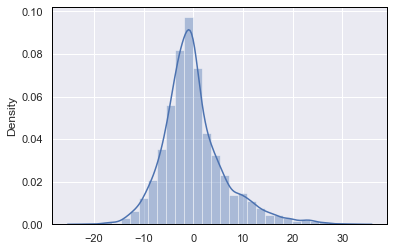

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


diff = y_test - y_pred_knn

sns.distplot(diff, bins=30)


In [53]:
def qq_plot_with_statsLib(in_arr: np.array):

    fig = plt.figure()
    ax = fig.add_subplot(111)

    in_df = pd.DataFrame(in_arr)

    in_df.columns = ['col1']
    
    ret = stats.probplot(in_df['col1'], dist="norm", plot=ax)
    
    ax.set_title("July 2016")
    # add x&y-axis label
#     plt.xlabel('x-label')
    plt.ylabel('Roughness residuals (cm)')
    
#     plt.show()
    plt.savefig('july2016') # either show or save

    return 0

0

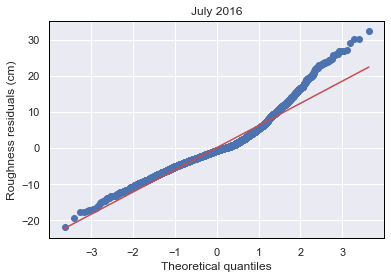

In [54]:
qq_plot_with_statsLib(diff)

0

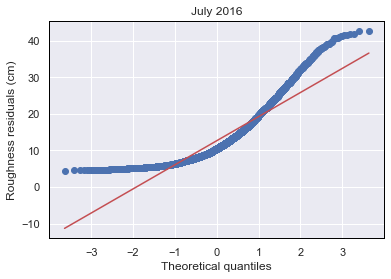

In [55]:
qq_plot_with_statsLib(y_test)

0

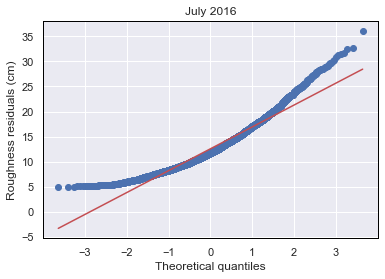

In [56]:
qq_plot_with_statsLib(y_pred_knn)

In [57]:
# from yellowbrick.regressor import ResidualsPlot

# visualizer = ResidualsPlot(knn_model, hist=False, qqplot=True)

# visualizer.fit(x_train, y_train)  # Fit the training data to the visualizer
# visualizer.score(x_test, y_test)  # Evaluate the model on the test data
# visualizer.show()                 # Finalize and render the figure


## >>> predicting transect block with my KNN >>>

In [58]:
# # order of cameras in training set
# x_train[0:5]

In [59]:
# # x_predict_3cams = 'build this df from 3 cameras of the image block'
# # home of 3 toa-refl 
# toa_refl_dir = '/Users/ehsanmos/MLP_dataset/transect_test_p79_b32'

# # 3 toa-refl for transect- later we can use masked-toa-refl because we are using a new logic in the next box to include negative pixels
# an = 'toa_refl_P079_O086932_B032_an_red.dat'
# cf = 'toa_refl_P079_O086932_B032_cf_red.dat'
# ca = 'toa_refl_P079_O086932_B032_ca_red.dat'


# # open and read each file
# an_arr = np.fromfile(os.path.join(toa_refl_dir, an), dtype=np.double)[0:1048576].reshape((512,2048))
# cf_arr = np.fromfile(os.path.join(toa_refl_dir, cf), dtype=np.double)[0:1048576].reshape((512,2048))
# ca_arr = np.fromfile(os.path.join(toa_refl_dir, ca), dtype=np.double)[0:1048576].reshape((512,2048))


In [60]:
# print(type(an_arr))
# print(an_arr.shape)

note: have negative (-1) pixels in toa-refl image; it represents the black area around the image block?



Q- first build X-train Test samples dataset and then predict?-> not doable

Q- why warning in prediction?-> changed training DS to list and resolved

Q- why prediction for a single block is so slow? -> warning removed, a bit faster

Q- how make a dataset from block first before prediction?

In [61]:
# # this prediction here only runs with 3 features/cams. if later we want to add lat/lon as feature, we need to include lat/lon for predcited transect too
# rough_predicted_arr = []

# for row in range(512):
#     for col in range(2048):
#         # check if a pixel in an is negative
#         if (an_arr[row,col] < 0):
#             rough_predicted_arr.append(an_arr[row,col]) # if negative, append to predicted array
#             continue
            
#         if (cf_arr[row,col] < 0):
#             rough_predicted_arr.append(cf_arr[row,col])
#             continue
            
#         if (ca_arr[row,col] < 0):
#             rough_predicted_arr.append(ca_arr[row,col])
#             continue
            
#         # make prediction for each single pixel
#         y_pred_for_pixel_knn = knn_model.predict([[an_arr[row,col], ca_arr[row,col], cf_arr[row,col]]]) # order based on training ds
# #         print(y_pred_for_pixel_knn[0][0])
#         rough_predicted_arr.append(y_pred_for_pixel_knn[0][0])

   

In [62]:
# print(type(rough_predicted_arr))
# print(len(rough_predicted_arr))

In [63]:
# pred = rough_predicted_arr[1000]
# print(pred)
# print(type(pred))

In [64]:
# # change to np.array?
# block_arr_p79_b32 = np.array(rough_predicted_arr).reshape(512,2048)
# print(type(block_arr_p79_b32))
# print(block_arr_p79_b32.shape)

In [65]:
# print(block_arr_p79_b32[0,1000])

In [66]:
# # this function plots rouhgness array
# def plot_here_and_write(in_arr, img_dir):
#     write_mode = 0
# #     img_label = 'path_'+path_num+'_'+'blocks_'+str(start_block)+'_'+str(end_block)+'_cam_'+cam
#     img_format = ".jpg"
#     %matplotlib inline 

#     plt.gray() # This will show the images in grayscale as default

#     plt.figure(figsize=(30,30))  # set the figure size

#     plt.imshow(in_arr)
#     plt.show()
    
#     if (write_mode):
#         print('save mode: on, we write images to disc')
        
#         out_img = img_label+img_format
#         out_img_fullpath = os.path.join(img_dir, out_img)
#         print("-> output img is: %s" %out_img_fullpath)
#         pltimg.imsave(out_img_fullpath, in_arr)
#         #     plt.savefig(out_img)
    
#     return 0

In [67]:
# plot_here_and_write(block_arr_p79_b32, out_dir)

In [68]:
# # Write array to a file as a binary to plot the roughness on transect and compare modeled/predicted roughnesss with measured/observed ATM across transect

# # set path
# out_dir = '/Users/ehsanmos/MLP_dataset/transect_test_p79_b32'
# out_bin = 'block_arr_p79_b32.dat'

# # write array as binary
# block_arr_p79_b32.tofile(os.path.join(out_dir, out_bin)) 




## >>> Generalized additive models (GAM) for regression >>>

In [69]:
# # GAM using a factor term; not good because we want to see the relationship between a input feature and the target 

# gam = LinearGAM(s(0) + s(1) + f(2)).fit(x_train, y_train)
# gam.summary()


In [70]:
# list(gam.statistics_.keys())

note: we use the partial dependence plot to visualize the relationships the model has learned

In [71]:
def partial_dependence_plots_1(gam):
    
    import matplotlib.pyplot as plt
    
#     titles = ['an', 'ca', 'cf']
    
    for i, term in enumerate(gam.terms):
        if term.isintercept:
            continue

        XX = gam.generate_X_grid(term=i)
        pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)

        plt.figure()
        plt.plot(XX[:, term.feature], pdep)
        plt.plot(XX[:, term.feature], confi, c='r', ls='--')
        plt.title(repr(term))
        plt.show()
    
    return 0
    
    

    
def partial_dependence_plots_2(gam):
    plt.figure();
    fig, axs = plt.subplots(1,3);

    titles = ['an', 'ca', 'cf']

    for i, ax in enumerate(axs):
        XX = gam.generate_X_grid(term=i)
        ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
        ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    #     if i == 0:
    #         ax.set_ylim(-30,30)
        ax.set_title(titles[i]);
        
    return 0

In [72]:
x_train[0:5]

[[0.761025, 0.847888, 0.931603],
 [0.814978, 0.880688, 0.969662],
 [0.387839, 0.524608, 0.686127],
 [0.781544, 0.86914, 0.951352],
 [0.783482, 0.872893, 0.960854]]

In [75]:
splines = 200
gam_model = GAM(s(0, n_splines=splines) + 
                s(1, n_splines=splines) + 
                s(2, n_splines=splines)).fit(x_train, y_train)



'''spline f(.) only on 3 cameras
'''

# gam_model = GAM(te(0,1) +
#                 s(2, n_splines=20) +
#                 s(3, n_splines=20) + 
#                 s(4, n_splines=20)).fit(x_train, y_train)


# gam_model = GAM(s(2, n_splines=20) +
#                 s(3, n_splines=20) + 
#                 s(4, n_splines=20)).fit(x_train, y_train)


gam_model.summary()


GAM                                                                                                       
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    357.8818
Link Function:                     IdentityLink Log Likelihood:                                -53145.8173
Number of Samples:                        11634 AIC:                                           107009.3983
                                                AICc:                                          107032.3101
                                                GCV:                                               40.1747
                                                Scale:                                             37.9565
                                                Pseudo R-Squared:                                     0.22
Feature Function                  Lam

/var/folders/cg/r5rsmy1146d38c9kj97z_55w0000gn/T/ipykernel_2243/3040378330.py:22: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_model.summary()


'\nnote: the ca plot shows that the higher the the ca, the rougher the surface is; \nand cf plot shows that the higher cf goes, the smoother the surface gets;\nan plot does not show any relationship with roughness\n\nin other words, roughness increases as the ca gets larger, and roughness decreases as the cf gets larger. \nalso, an has little influence on the roughness.\n'

<Figure size 432x288 with 0 Axes>

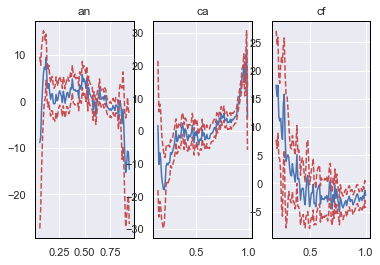

In [74]:
# plot the partial dependece plots 

partial_dependence_plots_2(gam_model)

'''
note: the ca plot shows that the higher the the ca, the rougher the surface is; 
and cf plot shows that the higher cf goes, the smoother the surface gets;
an plot does not show any relationship with roughness

in other words, roughness increases as the ca gets larger, and roughness decreases as the cf gets larger. 
also, an has little influence on the roughness.
'''

